## Building Network Models
# UB Species-collectors Network
### Projections

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import scn
from setupmodels import occs
from setupmodels import ni

In [4]:
# Importing libraries for analysis
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
graphsdir = os.path.abspath('./graphs')

if not os.path.isdir(graphsdir):
    !mkdir graphs

---

## The SCN Network

In [19]:
print(nx.info(scn))
print('Number of species nodes:',len(scn.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 22112
Number of edges: 142647
Average degree:  12.9022
Number of species nodes: 15344
Number of collectors nodes: 6768


---

## Obtaining taxonomic aggregations

#### Aggregation by family

In [8]:
g = dict( occs[['family','species']].groupby('family').apply(lambda g: set(g['species'])) )

In [9]:
scn_family = scn.taxonomicAggregation(g)

In [17]:
print(nx.info(scn_family))
print('Number of species nodes:',len(scn_family.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn_family.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 7242
Number of edges: 43803
Average degree:  12.0969
Number of species nodes: 474
Number of collectors nodes: 6768


#### Aggregation by genus

In [10]:
g = dict( occs[['genus','species']].groupby('genus').apply(lambda g: set(g['species'])) )

In [11]:
scn_genus = scn.taxonomicAggregation(g)

In [38]:
print(nx.info(scn_genus))
print('Number of species nodes:',len(scn_genus.listSpeciesNodes()))
print('Number of collectors nodes:',len(scn_genus.listCollectorsNodes()))

Name: 
Type: SpeciesCollectorsNetwork
Number of nodes: 9937
Number of edges: 87632
Average degree:  17.6375
Number of species nodes: 3169
Number of collectors nodes: 6768


---

## Bipartite projections

* The density of projected networks increase when aggregating them on higher taxonomic ranks.
* Species projections are denser than collectors projections, although the absolute number of edges in species projections (aggregated by genus and family) is lower than in collectors.

### Collectors projections

The number of nodes in SCN collectors projections does not change with successive taxonomic aggregations, but the number of edges does! The number of edges (and consequently graph density) increases for taxonomic aggregations on higher ranks.

In [39]:
# Non-aggregated SCN
scn_projCol = scn.project('collectors',rule='cosine_similarity')

In [40]:
print(nx.info(scn_projCol))
print('Density:',nx.density(scn_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 834239
Average degree: 246.5245
Density: 0.03643040153491373


In [21]:
# Genus aggregated SCN
scn_genus_projCol = scn_genus.project('collectors',rule='cosine_similarity')

In [33]:
print(nx.info(scn_genus_projCol))
print('Density:',nx.density(scn_genus_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 2509837
Average degree: 741.6776
Density: 0.10960212804386187


In [29]:
# Family aggregated SCN
scn_family_projCol = scn_family.project('collectors',rule='cosine_similarity')

In [34]:
print(nx.info(scn_family_projCol))
print('Density:',nx.density(scn_family_projCol))

Name: 
Type: Graph
Number of nodes: 6768
Number of edges: 5431799
Average degree: 1605.1415
Density: 0.23720135192306147


### Species projections

Non-aggregated SCN species projections have lower density than their aggregated counterparts, although the number of nodes (and specially edges) is much greater. Thus, they become computationally hard to deal with.

The number of nodes and edges in SCN species projections aggregated on higher ranks are reduced, although the network density increases, making it harder to obtain relevant relationships without filtering.

In [41]:
# Non-aggregated SCN
scn_projSp = scn.project('species',rule='cosine_similarity')

In [42]:
print(nx.info(scn_projSp))
print('Density:',nx.density(scn_projSp))

Name: 
Type: Graph
Number of nodes: 15344
Number of edges: 19482923
Average degree: 2539.4842
Density: 0.1655141907295104


In [22]:
# Genus aggregated SCN
scn_genus_projSp = scn_genus.project('species',rule='cosine_similarity')

In [35]:
print(nx.info(scn_genus_projSp))
print('Density:',nx.density(scn_genus_projSp))

Name: 
Type: Graph
Number of nodes: 3169
Number of edges: 1188065
Average degree: 749.8044
Density: 0.23668066751452677


In [31]:
# Family aggregated SCN
scn_family_projSp = scn_family.project('species',rule='cosine_similarity')

In [36]:
print(nx.info(scn_family_projSp))
print('Density:',nx.density(scn_family_projSp))

Name: 
Type: Graph
Number of nodes: 474
Number of edges: 43756
Average degree: 184.6245
Density: 0.39032658049437563


---

## Threshold vs. Density (family vs genus aggregations)

### Collectors projections

In [43]:
m_scn_family_projCol = nx.adjacency_matrix(scn_family_projCol)
m_scn_genus_projCol = nx.adjacency_matrix(scn_genus_projCol)
m_scn_noagg_projCol = nx.adjacency_matrix(scn_projCol)

In [44]:
calculateDensity = lambda m: len(m.data)/np.prod(m.shape) # calculates the density of a sparse matrix

from copy import deepcopy
def filterMatrix(m,thresh):
    # Filters a sparse matrix given a threshold 
    m_filtered = deepcopy(m)
    m_filtered.data = np.where(m_filtered.data >= thresh, m_filtered.data, 0)
    m_filtered.eliminate_zeros()
    return m_filtered

In [45]:
X = np.logspace(-3,0) # threshold values
y_noagg = np.array( [ calculateDensity(filterMatrix(m_scn_noagg_projCol,thresh)) for thresh in X ] )
y_genus = np.array( [ calculateDensity(filterMatrix(m_scn_genus_projCol,thresh)) for thresh in X ] )
y_family = np.array( [ calculateDensity(filterMatrix(m_scn_family_projCol,thresh)) for thresh in X ] )

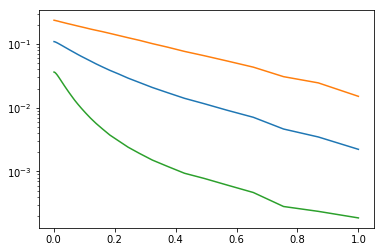

In [46]:
plt.plot(X,y_genus)
plt.plot(X,y_family)
plt.plot(X,y_noagg)

plt.yscale('log')

In [ ]:
# look at the genus-aggregated graph
